# Notebook 022: Build Model Features

This notebook combines features from the cleansed crime incidents dataset as well as a number of other datasets to append each crime incident record with the additional engineered features used in our analysis

In [1]:
import urllib
import os
import operator
import pathlib
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
%matplotlib inline

In [144]:
DATA_ROOT = '../data/'
FIGURES_ROOT = '../figures/crime'

READDIR_ROOT = os.path.join(DATA_ROOT, 'raw')
WRITEDIR_ROOT = os.path.join(DATA_ROOT, 'interim/crime')
FEATURES_ROOT = os.path.join(DATA_ROOT, 'processed')

readfile_crime = os.path.join(FEATURES_ROOT, 'crime-records-for-model-no-features-added.csv')
readfile_property = os.path.join(FEATURES_ROOT, 'property-assessment-features-2013-2019.csv')
readfile_weather = os.path.join(FEATURES_ROOT, 'boston-daily-weather-20140101-20190831.csv')
readfile_streetlights = os.path.join(READDIR_ROOT, 'boston/streetlights.csv')
readfile_demographics = os.path.join(DATA_ROOT, 'interim/demographics_master_neighborhood.csv')
readfile_colleges = os.path.join(FEATURES_ROOT, 'colleges_universities_final.csv')
readfile_schools_public = os.path.join(READDIR_ROOT, 'boston/public-k12-schools.csv')
readfile_schools_nonpublic = os.path.join(READDIR_ROOT, 'boston/nonpublic-k12-schools.csv')
# readfile_violations = 

readfile_zipshapes = os.path.join(READDIR_ROOT, 'shapefile/zipcodes/ZIP_Codes.shp')
readfile_cityshape = os.path.join(READDIR_ROOT, 'shapefile/city-boundary/City_of_Boston_Boundary.shp')
readfile_streetshapes = os.path.join(READDIR_ROOT, 'shapefile/street-segments/Boston_Street_Segments.shp')
readfile_tractshapes = os.path.join(READDIR_ROOT, 'shapefile/census-tracts/Census_2010_Tracts.shp')
readfile_hoodshapes = os.path.join(READDIR_ROOT, 'shapefile/boston-neighborhoods/Boston_Neighborhoods.shp')
readfile_zonesubshapes = os.path.join(READDIR_ROOT, 'shapefile/zoning-subdistricts/Zoning_Subdistricts.shp')
readfile_openshapes = os.path.join(READDIR_ROOT, 'shapefile/open-spaces/Open_Space.shp')

print(
    'readfile paths for datasets used in this notebook are:\n\t{}\n\t{}\n\t{}'.format(
        readfile_crime, readfile_property, readfile_weather, readfile_zipshapes, WRITEDIR_ROOT
    )
)

readfile paths for datasets used in this notebook are:
	../data/processed/crime-records-for-model-no-features-added.csv
	../data/processed/property-assessment-features-2013-2019.csv
	../data/processed/boston-daily-weather-20140101-20190831.csv


## Read in datasources for merging

In [3]:
df_crime = pd.read_csv(readfile_crime, dtype=str)
df_property = pd.read_csv(readfile_property, dtype={'shape-id': str, 'fiscal-year': int})
df_weather = pd.read_csv(readfile_weather)
df_lights = pd.read_csv(readfile_streetlights)
df_colleges = pd.read_csv(readfile_colleges)
df_schoolspub = pd.read_csv(readfile_schools_public)
df_schoolsnonpub = pd.read_csv(readfile_schools_nonpublic)

df_crime['lat'] = df_crime['lat'].astype(float)
df_crime['lon'] = df_crime['lon'].astype(float)

In [4]:
# print info for each dataframe
print('CRIME DATAFRAME\n')
df_crime.info()
display(df_crime.head())
print('\n\nPROPERTY ASSESSMENT FEATURES DATAFRAME\n')
df_property.info()
display(df_property.head())
print('\n\nWEATHER FEATURES DATAFRAME\n')
df_weather.info()
display(df_weather.head())

CRIME DATAFRAME

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 151072 entries, 0 to 151071
Data columns (total 18 columns):
crime-type             151072 non-null object
INCIDENT_NUMBER        151072 non-null object
OFFENSE_DESCRIPTION    151072 non-null object
timestamp              151072 non-null object
lat                    151072 non-null float64
lon                    151072 non-null float64
year                   151072 non-null object
month                  151072 non-null object
day-of-week            151072 non-null object
hour                   151072 non-null object
ZIP5                   151044 non-null object
ZIP5_area              151044 non-null object
Name                   151002 non-null object
Neighborhood_area      151002 non-null object
Neighborhood_area_2    151002 non-null object
TRACTCE10              151072 non-null object
TRACTCE10_area         151072 non-null object
TRACTCE10_area_2       151072 non-null object
dtypes: float64(2), object(16)
memory usag

,crime-type,INCIDENT_NUMBER,OFFENSE_DESCRIPTION,timestamp,lat,lon,year,month,day-of-week,hour,ZIP5,ZIP5_area,Name,Neighborhood_area,Neighborhood_area_2,TRACTCE10,TRACTCE10_area,TRACTCE10_area_2
0,fraud,I192078177,forgery / counterfeiting,2019-08-01 17:46:00,42.304922,-71.102981,2019,8,Thursday,17,02130,105221153.02392578,Roxbury,91844545.97481573,3.29,980300,22640579.7627,3847996.3515625
1,harassment-disturbance,I192078061,harassment,2019-06-12 21:00:00,42.355553,-71.152747,2019,6,Wednesday,21,02135,78620825.92480469,Brighton,80167877.560494,2.88,000202,6475526.5708,1102312.71484375
2,theft,I192078038,larceny theft of mv parts & accessories,2019-03-10 08:00:00,42.345625,-71.041291,2019,3,Sunday,8,02210,32373210.07080078,South Boston Waterfront,27087395.391558826,0.97,060600,20379799.0356,3468813.69921875
3,theft,I192078015,larceny all others,2019-07-08 10:29:00,42.339304,-71.051604,2019,7,Monday,10,02127,67536142.7421875,South Boston,62721306.143917084,2.25,060700,1380119.5437,234830.15234375
4,theft,I192077997,auto theft - leased/rented vehicle,2019-04-13 08:00:00,42.328564,-71.068353,2019,4,Saturday,8,02119,44511498.52441406,Roxbury,91844545.97481573,3.29,080100,11047170.5891,1879154.8203125




PROPERTY ASSESSMENT FEATURES DATAFRAME

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13002 entries, 0 to 13001
Data columns (total 5 columns):
shape-id       13002 non-null object
fiscal-year    13002 non-null int64
value          12927 non-null float64
shape-type     13002 non-null object
metric         13002 non-null object
dtypes: float64(1), int64(1), object(3)
memory usage: 508.0+ KB


,shape-id,fiscal-year,value,shape-type,metric
0,00000,2013,37000.0,zipcode,residential-median-value
1,02026,2013,NaN,zipcode,residential-median-value
2,02108,2013,691300.0,zipcode,residential-median-value
3,02109,2013,456950.0,zipcode,residential-median-value
4,02110,2013,566512.5,zipcode,residential-median-value




WEATHER FEATURES DATAFRAME

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1339 entries, 0 to 1338
Data columns (total 13 columns):
date            1339 non-null object
weathercodes    660 non-null object
sunrise         1339 non-null int64
sunset          1339 non-null int64
tempavg         1339 non-null float64
tempmax         1339 non-null float64
tempmin         1339 non-null float64
humavg          1338 non-null float64
windavg         1339 non-null float64
windsustain     1339 non-null int64
windmax         1339 non-null int64
precip          1339 non-null float64
snowfall        1339 non-null float64
dtypes: float64(7), int64(4), object(2)
memory usage: 136.1+ KB


,date,weathercodes,sunrise,sunset,tempavg,tempmax,tempmin,humavg,windavg,windsustain,windmax,precip,snowfall
0,2016-01-01,NaN,713,1622,2.8,5.0,0.6,58.0,12.7,23,32,0.0,0.0
1,2016-01-02,NaN,714,1623,2.2,4.4,-0.6,53.0,13.3,22,28,0.0,0.0
2,2016-01-03,NaN,714,1624,3.3,6.7,-0.6,57.0,11.7,21,28,0.0,0.0
3,2016-01-04,SN,714,1625,-3.9,2.2,-10.0,59.0,12.4,21,28,0.0,0.0
4,2016-01-05,NaN,714,1626,-8.3,-3.3,-13.3,41.0,10.0,18,23,0.0,0.0


## Merge property assessment features

In [5]:
# subset property features data to contain only census-tract level metrics
df_property = df_property.loc[df_property['shape-type']=='census tract']
df_property.shape

(9570, 5)

In [6]:
# make list of metrics for matching
print(df_property['metric'].value_counts())

prop_metrics_list = list(df_property['metric'].value_counts().index)

print()
print(prop_metrics_list)

industrial-mix-ratio                 1267
commercial-mix-ratio                 1267
owner-occupied-ratio                 1190
residential-median-value             1183
residential-gini-coef                1183
industrial-mix-ratio-3yr-cagr         724
commercial-mix-ratio-3yr-cagr         724
owner-occupied-ratio-3yr-cagr         680
residential-median-value-3yr-cagr     676
residential-gini-coef-3yr-cagr        676
Name: metric, dtype: int64

['industrial-mix-ratio', 'commercial-mix-ratio', 'owner-occupied-ratio', 'residential-median-value', 'residential-gini-coef', 'industrial-mix-ratio-3yr-cagr', 'commercial-mix-ratio-3yr-cagr', 'owner-occupied-ratio-3yr-cagr', 'residential-median-value-3yr-cagr', 'residential-gini-coef-3yr-cagr']


In [7]:
# create temporary match-key column for crime dataset record matching
df_crime['tract-match-key'] = (df_crime['TRACTCE10'].astype(str) + df_crime['year'].astype(str)).values

df_crime['tract-match-key'].head()

0    9803002019
1    0002022019
2    0606002019
3    0607002019
4    0801002019
Name: tract-match-key, dtype: object

In [8]:
# Start list of "temporary match" column names for dropping before saving final dataframe

temp_drop_list = ['tract-match-key']

In [9]:
# create equivalent match-key column for property metrics dataframe
df_property['shape_match'] = (df_property['shape-id'].astype(str) + df_property['fiscal-year'].astype(str)).values
df_property.head()

,shape-id,fiscal-year,value,shape-type,metric,shape_match
420,000100,2013,402150.0,census tract,residential-median-value,0001002013
421,000201,2013,444900.0,census tract,residential-median-value,0002012013
422,000202,2013,447581.0,census tract,residential-median-value,0002022013
423,000301,2013,412700.0,census tract,residential-median-value,0003012013
424,000302,2013,326650.0,census tract,residential-median-value,0003022013


In [10]:
############################################
# Merge property features to crime dataframe
############################################

for metric in prop_metrics_list:
    temp_match_dict = dict(
        zip(
            df_property.loc[df_property['metric']==metric][['value', 'shape_match']].values[:,1],
            df_property.loc[df_property['metric']==metric][['value', 'shape_match']].values[:,0]
        )
    )
    df_crime[metric] = df_crime['tract-match-key'].copy().map(temp_match_dict)

In [11]:
# view resulting dataframe with added property features
print(df_crime.info())
df_crime.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 151072 entries, 0 to 151071
Data columns (total 29 columns):
crime-type                           151072 non-null object
INCIDENT_NUMBER                      151072 non-null object
OFFENSE_DESCRIPTION                  151072 non-null object
timestamp                            151072 non-null object
lat                                  151072 non-null float64
lon                                  151072 non-null float64
year                                 151072 non-null object
month                                151072 non-null object
day-of-week                          151072 non-null object
hour                                 151072 non-null object
ZIP5                                 151044 non-null object
ZIP5_area                            151044 non-null object
Name                                 151002 non-null object
Neighborhood_area                    151002 non-null object
Neighborhood_area_2                  151002 non

,crime-type,INCIDENT_NUMBER,OFFENSE_DESCRIPTION,timestamp,lat,lon,year,month,day-of-week,hour,...,industrial-mix-ratio,commercial-mix-ratio,owner-occupied-ratio,residential-median-value,residential-gini-coef,industrial-mix-ratio-3yr-cagr,commercial-mix-ratio-3yr-cagr,owner-occupied-ratio-3yr-cagr,residential-median-value-3yr-cagr,residential-gini-coef-3yr-cagr
0,fraud,I192078177,forgery / counterfeiting,2019-08-01 17:46:00,42.304922,-71.102981,2019,8,Thursday,17,...,0.000294,0.000000,0.000000,756500.0,0.000000,-0.034814,0.000000,0.000000,0.024264,0.000000
1,harassment-disturbance,I192078061,harassment,2019-06-12 21:00:00,42.355553,-71.152747,2019,6,Wednesday,21,...,0.000000,0.069416,0.550355,745950.0,0.199606,0.000000,-0.010424,-0.028224,0.068142,0.011166
2,theft,I192078038,larceny theft of mv parts & accessories,2019-03-10 08:00:00,42.345625,-71.041291,2019,3,Sunday,8,...,0.000938,0.478130,0.456287,538500.0,0.228793,-0.084828,0.010549,-0.014131,0.060340,0.018436
3,theft,I192078015,larceny all others,2019-07-08 10:29:00,42.339304,-71.051604,2019,7,Monday,10,...,0.000000,0.000000,NaN,NaN,NaN,0.000000,0.000000,NaN,NaN,NaN
4,theft,I192077997,auto theft - leased/rented vehicle,2019-04-13 08:00:00,42.328564,-71.068353,2019,4,Saturday,8,...,0.076862,0.375058,0.460751,355500.0,0.172898,0.060168,-0.007779,-0.023444,0.082123,0.025972


## Merge weather data features

In [12]:
# create temporary date match column and add to drop list
temp_drop_list = temp_drop_list + ['date']

df_crime['date'] = df_crime['timestamp'].str[:10]

In [13]:
# create list of weather-related column names for later manipulation
weather_match_cols = df_weather.columns

weather_match_cols

Index(['date', 'weathercodes', 'sunrise', 'sunset', 'tempavg', 'tempmax',
       'tempmin', 'humavg', 'windavg', 'windsustain', 'windmax', 'precip',
       'snowfall'],
      dtype='object')

In [14]:
# merge weather values to crime data 
df_crime = df_crime.merge(df_weather, how='left', on='date')

# print results
df_crime.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 151072 entries, 0 to 151071
Data columns (total 42 columns):
crime-type                           151072 non-null object
INCIDENT_NUMBER                      151072 non-null object
OFFENSE_DESCRIPTION                  151072 non-null object
timestamp                            151072 non-null object
lat                                  151072 non-null float64
lon                                  151072 non-null float64
year                                 151072 non-null object
month                                151072 non-null object
day-of-week                          151072 non-null object
hour                                 151072 non-null object
ZIP5                                 151044 non-null object
ZIP5_area                            151044 non-null object
Name                                 151002 non-null object
Neighborhood_area                    151002 non-null object
Neighborhood_area_2                  151002 non

## Create night time feature using sunrise and sunset data from weather merge

In [15]:
# convert timestamp to datetime data type for ease of use
df_crime['timestamp'] = pd.to_datetime(df_crime['timestamp'])

# create time values for each record in minutes
df_crime['time'] = (df_crime['timestamp'].dt.hour * 60) + df_crime['timestamp'].dt.minute

In [16]:
# create night time indicator feature
df_crime['night'] = (
    (df_crime['time'] < df_crime['sunrise']) | (df_crime['time'] > df_crime['sunset'])
).astype(int)

In [17]:
# check results
df_crime[['timestamp', 'year', 'month', 'hour', 'time', 'sunrise', 'sunset', 'night']].head()

,timestamp,year,month,hour,time,sunrise,sunset,night
0,2019-08-01 17:46:00,2019,8,17,1066,436,1904,0
1,2019-06-12 21:00:00,2019,6,21,1260,407,1921,0
2,2019-03-10 08:00:00,2019,3,8,480,605,1744,1
3,2019-07-08 10:29:00,2019,7,10,629,415,1923,0
4,2019-04-13 08:00:00,2019,4,8,480,507,1823,1


In [18]:
# add additional columns to drop prior to saving
temp_drop_list = temp_drop_list + ['time', 'sunrise', 'sunset']

## Create streetlight density feature

In [19]:
def distance(locs1, locs2, r=6371, meters=True):
    """
    Converts distances between lat/lon points to meters using the Haversine
    formula for measuring distance on a sphere

    If the desire is to measure pairwise distances between two coordinate
    arrays of equal length, or between two single sets of coordinates, this
    function can simply be called as `distance(locs1, locs2)`

    If the desire is to measure the distances of each coordinate in array 1
    all coordinates in array 2, the function needs to be called in this
    manner `distance(locs1[:, None], locs2)`
    
    locs1: np.array or list of lat/lon points
    locs2: np.array or list of lat/lon points
    r: float, default=6371, great sphere approximated radius of the earth
       in kilometers
    meters: boolean, default=True, specifies the output
            units of the distances returned by this function, meters if True,
            and kilometers if False
    
    returns: np.array of the distances between coordinates in either meters
             or kilometers
    """
    if meters:
        r = r * 1000
    
    # convert lat/lon coordinates to radians
    locs1 = locs1 * np.pi / 180
    locs2 = locs2 * np.pi / 180
    
    cos_lat1 = np.cos(locs1[..., 0])
    cos_lat2 = np.cos(locs2[..., 0])
    
    cos_lat_d = np.cos(locs1[..., 0] - locs2[..., 0])
    cos_lon_d = np.cos(locs1[..., 1] - locs2[..., 1])
    
    a = (1 - cos_lat_d)/2 + cos_lat1 * cos_lat2 * (1 - cos_lon_d)/2
    
    return 2 * r * np.arcsin(np.sqrt(a))

In [20]:
# test distance between widener and boston city hall to confirm
# distance function is working correctly
test_1 = np.array((42.373392, -71.116507))
test_2 = np.array((42.360126, -71.059320))

distance(test_2, test_1)

4924.382348283844

In [21]:
# convert crime locations and streetlight locations to numpy arrays
crime_locs = df_crime[['lat','lon']].values
light_locs = df_lights[['Lat', 'Long']].values

In [22]:
%%time
threshold = 100 # distance in meters
n_splits = 155 # split into batches to prevent memory allocation issues
splits = np.array_split(crime_locs, n_splits)

#calculate streetlight densities, and use tqdm to track progress
for i, split in tqdm(enumerate(splits)):
    distances = distance(split[:, None], light_locs)
    densities = np.sum((distances<threshold).astype(int), axis=1).reshape(-1,1)
    if i == 0:
        streetlights = densities.copy()
    else:
        streetlights = np.vstack([streetlights.copy(), densities.copy()])


CPU times: user 2min 45s, sys: 42.1 s, total: 3min 27s
Wall time: 3min 27s


(151072, 1)


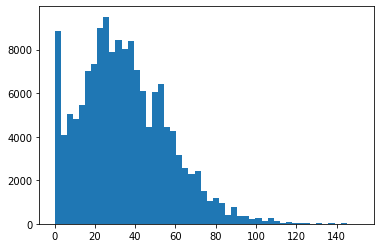

In [140]:
print(streetlights.shape)

plt.hist(streetlights, bins=50)
plt.show()

In [24]:
# add streetlights feature to crime data
df_crime['streetlights'] = streetlights

In [25]:
df_crime.info()
df_crime.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 151072 entries, 0 to 151071
Data columns (total 45 columns):
crime-type                           151072 non-null object
INCIDENT_NUMBER                      151072 non-null object
OFFENSE_DESCRIPTION                  151072 non-null object
timestamp                            151072 non-null datetime64[ns]
lat                                  151072 non-null float64
lon                                  151072 non-null float64
year                                 151072 non-null object
month                                151072 non-null object
day-of-week                          151072 non-null object
hour                                 151072 non-null object
ZIP5                                 151044 non-null object
ZIP5_area                            151044 non-null object
Name                                 151002 non-null object
Neighborhood_area                    151002 non-null object
Neighborhood_area_2                  15

,crime-type,INCIDENT_NUMBER,OFFENSE_DESCRIPTION,timestamp,lat,lon,year,month,day-of-week,hour,...,tempmin,humavg,windavg,windsustain,windmax,precip,snowfall,time,night,streetlights
0,fraud,I192078177,forgery / counterfeiting,2019-08-01 17:46:00,42.304922,-71.102981,2019,8,Thursday,17,...,23.3,52.0,7.9,14,20,0.00,0.0,1066,0,7
1,harassment-disturbance,I192078061,harassment,2019-06-12 21:00:00,42.355553,-71.152747,2019,6,Wednesday,21,...,15.6,46.0,11.6,20,23,0.00,0.0,1260,0,8
2,theft,I192078038,larceny theft of mv parts & accessories,2019-03-10 08:00:00,42.345625,-71.041291,2019,3,Sunday,8,...,-0.6,83.0,12.8,25,30,0.46,0.9,480,1,26
3,theft,I192078015,larceny all others,2019-07-08 10:29:00,42.339304,-71.051604,2019,7,Monday,10,...,18.9,55.0,7.8,13,15,0.00,0.0,629,0,77
4,theft,I192077997,auto theft - leased/rented vehicle,2019-04-13 08:00:00,42.328564,-71.068353,2019,4,Saturday,8,...,13.9,75.0,14.0,24,32,0.28,0.0,480,1,17


## Create college proximity feature

In [28]:
df_colleges.info()
df_colleges.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57 entries, 0 to 56
Data columns (total 29 columns):
Unnamed: 0       57 non-null int64
OBJECTID         57 non-null int64
Match_type       57 non-null object
Ref_ID           57 non-null int64
ID1              42 non-null object
Id               57 non-null int64
SchoolId         57 non-null int64
Name             57 non-null object
Address          57 non-null object
City             57 non-null object
Zipcode          55 non-null float64
Contact          57 non-null object
PhoneNumbe       57 non-null object
YearBuilt        57 non-null int64
NumStories       57 non-null object
Cost             57 non-null int64
NumStudent       57 non-null int64
BackupPowe       57 non-null int64
ShelterCap       57 non-null object
Latitude         57 non-null float64
Longitude        57 non-null float64
Comment          57 non-null object
X                57 non-null float64
Y                57 non-null float64
NumStudent12     38 non-null float64


,Unnamed: 0,OBJECTID,Match_type,Ref_ID,ID1,Id,SchoolId,Name,Address,City,...,Latitude,Longitude,Comment,X,Y,NumStudent12,CampusHous,NumStudents13,URL,Address2013
0,0,1,NCES,0,"Fruit St, Boston, Massachusetts 02114-2696",98627,431594,Massachusetts General Hospital Dietetic Intern...,"Fruit St, Boston, Massachusetts 02114",West End,...,42.362591,-71.070141,0300381001,772340.999867,2.957450e+06,NaN,,20,NaN,NaN
1,1,2,NCES & Consortium,0,"8 Ashburton Place, Boston, Massachusetts 02108...",11959,168005,Suffolk University,"8 Ashburton Pl Beacon Hill, Boston, Massachuse...",Boston,...,42.358905,-71.061948,0302802001,774562.025937,2.956118e+06,9101.0,21%,8675,http://www.suffolk.edu,NaN
2,2,3,NCES & Consortium,0,"41 Berkeley St, Boston, Massachusetts 02116",16632,165884,Benjamin Franklin Institute of Technology,"41 Berkeley St, Boston, Massachusetts 02116",South End,...,42.346103,-71.070186,0500688000,772358.914857,2.951441e+06,472.0,,482,http://www.bfit.edu,NaN
3,3,4,NCES & Consortium,0,"250 New Rutherford Ave, Boston, Massachusetts ...",1949,165112,Bunker Hill Community College,"250 New Rutherford Ave, Boston, Massachusetts ...",Charlestown,...,42.375117,-71.069572,0202170000,772471.759776,2.962015e+06,12934.0,,14023,http://www.bhcc.mass.edu,NaN
4,4,5,NCES & Consortium,0,"36 1st Avenue, Boston, Massachusetts 02129-4557",9109,166869,MGH Institute of Health Professions,"36 1st Avenue, Boston, Massachusetts 02129",Charlestown,...,42.374917,-71.053972,0203504000,776687.321227,2.961964e+06,928.0,,1096,http://www.mghihp.edu,NaN


In [29]:
df_colleges.describe()

,Unnamed: 0,OBJECTID,Ref_ID,Id,SchoolId,Zipcode,YearBuilt,Cost,NumStudent,BackupPowe,Latitude,Longitude,X,Y,NumStudent12,NumStudents13,Address2013
count,57.000000,57.000000,57.0,57.000000,5.700000e+01,55.000000,57.000000,5.700000e+01,57.000000,57.0,57.000000,57.000000,57.000000,5.700000e+01,38.000000,57.000000,0.0
mean,28.000000,29.701754,0.0,42449.473684,4.260381e+05,113572.218182,1756.649123,3.810699e+07,2711.894737,0.0,42.344105,-71.092288,766386.991935,2.950685e+06,5140.105263,2627.456140,NaN
std,16.598193,17.085881,0.0,35280.176536,2.189046e+06,133406.639214,550.555871,9.133320e+07,6184.962668,0.0,0.021252,0.027650,7465.578714,7.754472e+03,8215.530661,5436.010486,NaN
min,0.000000,1.000000,0.0,1949.000000,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000,0.0,42.254000,-71.180351,742669.813147,2.917826e+06,98.000000,0.000000,NaN
25%,14.000000,15.000000,0.0,14097.000000,0.000000e+00,33951.000000,1899.000000,3.189600e+06,0.000000,0.0,42.339187,-71.103478,763367.006004,2.948882e+06,495.750000,0.000000,NaN
50%,28.000000,30.000000,0.0,17534.000000,1.656710e+05,67821.000000,1899.000000,8.714400e+06,594.000000,0.0,42.348500,-71.095494,765546.574808,2.952280e+06,1255.000000,698.000000,NaN
75%,42.000000,44.000000,0.0,86223.000000,1.672240e+05,138158.000000,1945.000000,2.681230e+07,1593.000000,0.0,42.351960,-71.070970,772164.999891,2.953518e+06,4739.000000,2264.000000,NaN
max,56.000000,59.000000,0.0,98627.000000,1.664520e+07,606500.000000,1999.000000,5.227396e+08,31960.000000,0.0,42.381010,-71.039202,780798.454737,2.964159e+06,32439.000000,32411.000000,NaN


In [72]:
%%time

# set distance in meters to identify crime proximal to colleges 
threshold = 500

# convert locations to numpy array for calculating distances
college_locs = df_colleges[['Latitude', 'Longitude']].values

# generate array of calculated distances for all crimes to all colleges
college_distances = distance(crime_locs[:, None], college_locs)

# identify minimum distances and associated college populations for each crime
min_idx = np.argmin(college_distances, axis=1)
min_distances = np.min(college_distances, axis=1)
min_populations = df_colleges['NumStudent'].values[min_idx]

# create proximity indicator based on threshold distance
near_college = (min_distances<threshold).astype(int)

CPU times: user 156 ms, sys: 44 ms, total: 200 ms
Wall time: 199 ms


In [75]:
print(
    'The number of crimes within {} meters of a college or university is:  {:,}'\
    ''.format(threshold, np.sum(near_college))
)

The number of crimes within 500 meters of a college or university is:  43,830


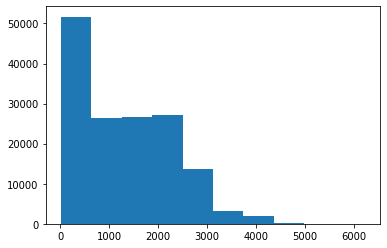

In [78]:
plt.hist(min_distances, bins=50)
plt.show();

In [76]:
df_crime['college_distance'] = min_distances
df_crime['college_near'] = near_college

In [77]:
df_crime.info()
df_crime.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 151072 entries, 0 to 151071
Data columns (total 47 columns):
crime-type                           151072 non-null object
INCIDENT_NUMBER                      151072 non-null object
OFFENSE_DESCRIPTION                  151072 non-null object
timestamp                            151072 non-null datetime64[ns]
lat                                  151072 non-null float64
lon                                  151072 non-null float64
year                                 151072 non-null object
month                                151072 non-null object
day-of-week                          151072 non-null object
hour                                 151072 non-null object
ZIP5                                 151044 non-null object
ZIP5_area                            151044 non-null object
Name                                 151002 non-null object
Neighborhood_area                    151002 non-null object
Neighborhood_area_2                  15

,crime-type,INCIDENT_NUMBER,OFFENSE_DESCRIPTION,timestamp,lat,lon,year,month,day-of-week,hour,...,windavg,windsustain,windmax,precip,snowfall,time,night,streetlights,college_distance,college_near
0,fraud,I192078177,forgery / counterfeiting,2019-08-01 17:46:00,42.304922,-71.102981,2019,8,Thursday,17,...,7.9,14,20,0.00,0.0,1066,0,7,2719.884235,0
1,harassment-disturbance,I192078061,harassment,2019-06-12 21:00:00,42.355553,-71.152747,2019,6,Wednesday,21,...,11.6,20,23,0.00,0.0,1260,0,8,1315.155113,0
2,theft,I192078038,larceny theft of mv parts & accessories,2019-03-10 08:00:00,42.345625,-71.041291,2019,3,Sunday,8,...,12.8,25,30,0.46,0.9,480,1,26,1543.501741,0
3,theft,I192078015,larceny all others,2019-07-08 10:29:00,42.339304,-71.051604,2019,7,Monday,10,...,7.8,13,15,0.00,0.0,629,0,77,1422.033321,0
4,theft,I192077997,auto theft - leased/rented vehicle,2019-04-13 08:00:00,42.328564,-71.068353,2019,4,Saturday,8,...,14.0,24,32,0.28,0.0,480,1,17,797.819824,0


## Create high school proximity feature

In [127]:
df_schoolspub.info()
display(df_schoolspub.head())
df_schoolsnonpub.info()
display(df_schoolsnonpub.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 131 entries, 0 to 130
Data columns (total 18 columns):
X             131 non-null float64
Y             131 non-null float64
OBJECTID_1    131 non-null int64
OBJECTID      131 non-null int64
BLDG_ID       131 non-null int64
BLDG_NAME     131 non-null object
ADDRESS       131 non-null object
CITY          131 non-null object
ZIPCODE       131 non-null int64
CSP_SCH_ID    131 non-null int64
SCH_ID        131 non-null int64
SCH_NAME      131 non-null object
SCH_LABEL     131 non-null object
SCH_TYPE      131 non-null object
SHARED        131 non-null object
COMPLEX       131 non-null object
POINT_X       131 non-null float64
POINT_Y       131 non-null float64
dtypes: float64(4), int64(6), object(8)
memory usage: 18.5+ KB


,X,Y,OBJECTID_1,OBJECTID,BLDG_ID,BLDG_NAME,ADDRESS,CITY,ZIPCODE,CSP_SCH_ID,SCH_ID,SCH_NAME,SCH_LABEL,SCH_TYPE,SHARED,COMPLEX,POINT_X,POINT_Y
0,-71.004121,42.388799,1,1,1,Guild Bldg,195 Leyden Street,East Boston,2128,4061,4061,Guild Elementary,Guild,ES,,,790128.152748,2.967094e+06
1,-71.030480,42.378545,2,2,3,"Kennedy, P Bldg",343 Saratoga Street,East Boston,2128,4541,4541,Kennedy Patrick Elem,PJ Kennedy,ES,,,783027.745829,2.963318e+06
2,-71.033891,42.375279,3,3,4,Otis Bldg,218 Marion Street,East Boston,2128,4322,4322,Otis Elementary,Otis,ES,,,782112.823908,2.962122e+06
3,-71.038011,42.378089,4,4,6,Odonnell Bldg,33 Trenton Street,East Boston,2128,4543,4543,O'Donnell Elementary,O'Donnell,ES,,,780994.000003,2.963140e+06
4,-71.034921,42.380957,5,5,7,East Boston High Bldg,86 White Street,East Boston,2128,1070,1070,East Boston High,East Boston HS,HS,,,781823.000004,2.964190e+06


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 82 entries, 0 to 81
Data columns (total 16 columns):
X             82 non-null float64
Y             82 non-null float64
OBJECTID_1    82 non-null int64
OBJECTID      82 non-null int64
SCHID         79 non-null float64
NAME          82 non-null object
ADDRESS       82 non-null object
TOWN_MAIL     82 non-null object
TOWN          82 non-null object
STATE         82 non-null object
ZIP           82 non-null object
PRINCIPAL     82 non-null object
PHONE         82 non-null object
FAX           82 non-null object
GRADES        82 non-null object
TYPE          82 non-null object
dtypes: float64(3), int64(2), object(11)
memory usage: 10.3+ KB


,X,Y,OBJECTID_1,OBJECTID,SCHID,NAME,ADDRESS,TOWN_MAIL,TOWN,STATE,ZIP,PRINCIPAL,PHONE,FAX,GRADES,TYPE
0,-71.105143,42.327676,85,163,5300.0,Roxbury Prep - Mission Hill,120 Fisher Avenue,Roxbury,BOSTON,MA,02120,Dana Lehman,617-566-2361,617-566-2373,"6,7,8",CHA
1,-71.058717,42.301403,86,153,5470.0,Helen Davis Leadership Academy Charter Public ...,23 Leonard Street,Boston,BOSTON,MA,02122,Karmala Sherwood,617-474-7950,617-474-7957,"6,7,8",CHA
2,-71.130150,42.306593,87,1100,350950.0,British School of Boston,416-420 Pond Street,Jamaica Plain,BOSTON,MA,02130,Bruce Robinson,617-522-2261,617-522-0385,"PK,K,1,2,3,4,5,6,7,8,9,10,11,12",PRI
3,-71.095739,42.349346,88,206,5230001.0,EDCO Collaborative - EDCO YOUTH ALT,"650 Beacon St , 3rd Floor",Boston,BOSTON,MA,02215,,617-262-9562,617-262-0098,,COP
4,-71.132132,42.244270,89,134,5600.0,Academy Of the Pacific Rim Charter Public School,1 Westinghouse Plaza,Hyde Park,BOSTON,MA,02136,Jenne Colasacco,617-361-0050,617-361-0045,"5,6,7,8,9,10,11,12",CHA


In [128]:
# subset public schools for only high schools
df_schoolspub = df_schoolspub.loc[
    (df_schoolspub['SCH_TYPE']=='HS') |
    (df_schoolspub['SCH_TYPE']=='6/7-12') | 
    (df_schoolspub['SCH_NAME'].str.contains('HS')) |
    (df_schoolspub['SCH_NAME'].str.contains('12')) |
    (df_schoolspub['SCH_NAME'].str.contains('High'))
]

# subset non-public schools for only high schools
df_schoolsnonpub = df_schoolsnonpub.loc[
    (df_schoolsnonpub['GRADES'].str.contains('12'))
]

# subset and rename columns to match for concatenating dataframes
new_cols = ['school_id', 'name', 'type', 'lat', 'lon', 'address', 'city', 'zip']

df_schoolspub = df_schoolspub[
    ['SCH_ID', 'SCH_NAME', 'SCH_TYPE', 'Y', 'X', 'ADDRESS', 'CITY', 'ZIPCODE']
].copy()

df_schoolspub.columns = new_cols

df_schoolsnonpub = df_schoolsnonpub[
    ['SCHID', 'NAME', 'GRADES', 'Y', 'X', 'ADDRESS', 'TOWN_MAIL', 'ZIP']
].copy()

df_schoolsnonpub.columns = new_cols

# concatenate public and non-public highschools
df_highschools = pd.concat([df_schoolspub, df_schoolsnonpub], ignore_index=True)

# fix school_id datatype and zipcodes
df_highschools['school_id'] = df_highschools['school_id'].astype(int)
df_highschools['zip'] = ('00000' + df_highschools['zip'].astype(str)).str[-5:]

In [129]:
# print concatenated results
df_highschools.info()
df_highschools.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53 entries, 0 to 52
Data columns (total 8 columns):
school_id    53 non-null int64
name         53 non-null object
type         53 non-null object
lat          53 non-null float64
lon          53 non-null float64
address      53 non-null object
city         53 non-null object
zip          53 non-null object
dtypes: float64(2), int64(1), object(5)
memory usage: 3.4+ KB


,school_id,name,type,lat,lon,address,city,zip
0,1070,East Boston High,HS,42.380957,-71.034921,86 White Street,East Boston,02128
1,1050,Charlestown High,HS,42.380119,-71.061071,240 Medford Street,Charlestown,02129
2,1200,Snowden International,HS,42.350579,-71.077971,150 Newbury Street,Boston,02116
3,1162,Excel High,HS,42.332869,-71.044891,95 G Street,South Boston,02127
4,1256,West Roxbury Academy,HS,42.282269,-71.174341,1205 V.F.W. Parkway,West Roxbury,02132


In [130]:
%%time
# find distance to nearest high school and create proximity indicator
# for each crime record

# set distance in meters to identify crime proximal to colleges 
threshold = 500

# convert locations to numpy array for calculating distances
highschool_locs = df_highschools[['lat', 'lon']].values

# generate array of calculated distances for all crimes to all colleges
highschool_distances = distance(crime_locs[:, None], highschool_locs)

# identify minimum distances and associated college populations for each crime
min_idx = np.argmin(highschool_distances, axis=1)
min_distances = np.min(highschool_distances, axis=1)
min_name = df_highschools['name'].values[min_idx]

# create proximity indicator based on threshold distance
near_highschool = (min_distances<threshold).astype(int)

CPU times: user 152 ms, sys: 40.1 ms, total: 192 ms
Wall time: 191 ms


In [134]:
print(
    'The number of crimes within {} meters of a college or university is:  {:,}'\
    ''.format(threshold, np.sum(near_highschool))
)

The number of crimes within 500 meters of a college or university is:  53,792


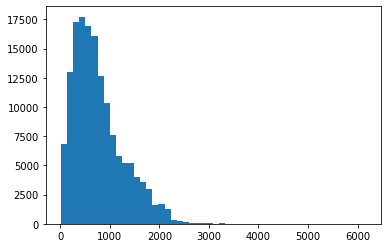

In [141]:
plt.hist(min_distances, bins=50)
plt.show()

In [142]:
df_crime['highschool_distance'] = min_distances
df_crime['highschool_near'] = near_highschool

In [143]:
df_crime.info()
df_crime.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 151072 entries, 0 to 151071
Data columns (total 49 columns):
crime-type                           151072 non-null object
INCIDENT_NUMBER                      151072 non-null object
OFFENSE_DESCRIPTION                  151072 non-null object
timestamp                            151072 non-null datetime64[ns]
lat                                  151072 non-null float64
lon                                  151072 non-null float64
year                                 151072 non-null object
month                                151072 non-null object
day-of-week                          151072 non-null object
hour                                 151072 non-null object
ZIP5                                 151044 non-null object
ZIP5_area                            151044 non-null object
Name                                 151002 non-null object
Neighborhood_area                    151002 non-null object
Neighborhood_area_2                  15

,crime-type,INCIDENT_NUMBER,OFFENSE_DESCRIPTION,timestamp,lat,lon,year,month,day-of-week,hour,...,windmax,precip,snowfall,time,night,streetlights,college_distance,college_near,highschool_distance,highschool_near
0,fraud,I192078177,forgery / counterfeiting,2019-08-01 17:46:00,42.304922,-71.102981,2019,8,Thursday,17,...,20,0.00,0.0,1066,0,7,2719.884235,0,557.631565,0
1,harassment-disturbance,I192078061,harassment,2019-06-12 21:00:00,42.355553,-71.152747,2019,6,Wednesday,21,...,23,0.00,0.0,1260,0,8,1315.155113,0,760.669282,0
2,theft,I192078038,larceny theft of mv parts & accessories,2019-03-10 08:00:00,42.345625,-71.041291,2019,3,Sunday,8,...,30,0.46,0.9,480,1,26,1543.501741,0,837.894451,0
3,theft,I192078015,larceny all others,2019-07-08 10:29:00,42.339304,-71.051604,2019,7,Monday,10,...,15,0.00,0.0,629,0,77,1422.033321,0,903.657571,0
4,theft,I192077997,auto theft - leased/rented vehicle,2019-04-13 08:00:00,42.328564,-71.068353,2019,4,Saturday,8,...,32,0.28,0.0,480,1,17,797.819824,0,985.466816,0


## Create demographics features

In [167]:
df_demographics = pd.read_csv(readfile_demographics)

In [168]:
df_demographics.info()
df_demographics.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23 entries, 0 to 22
Data columns (total 73 columns):
Unnamed: 0                                      23 non-null int64
Location                                        23 non-null object
Total-Population_x                              23 non-null float64
Median-Age                                      23 non-null float64
0:9-Years                                       23 non-null float64
0:9-Percentage                                  23 non-null float64
10:19-Years                                     23 non-null float64
10:19-Percentage                                23 non-null float64
20:34-Years                                     23 non-null float64
20:34-Percentage                                23 non-null float64
35:54-Years                                     23 non-null float64
35:54-Percentage                                23 non-null float64
55-64 years                                     23 non-null float64
55:64-Percentage

,Unnamed: 0,Location,Total-Population_x,Median-Age,0:9-Years,0:9-Percentage,10:19-Years,10:19-Percentage,20:34-Years,20:34-Percentage,...,Enrolled-Grade-5:8,Enrolled-Grade-5:8-Percentage,Enrolled-Grade-9:12,Enrolled-Grade-9:12-Percentage,Enrolled-College-Undergraduate,Enrolled-College-Undergraduate-Percentage,Graduate-Or-Professional-School,Graduate-Or-Professional-School-Percentage,Not-Enrolled-In-School,Not-Enrolled-In-School-Percentage
0,0,Allston,19363.0,26.0,550.0,0.028405,2691.0,0.138976,13084.0,0.675722,...,162.0,0.014313,77.0,0.006803,6630.0,0.585793,4106.0,0.362785,7856.0,0.409721
1,1,Back Bay,18176.0,33.0,798.0,0.043904,1632.0,0.089789,7498.0,0.412522,...,227.0,0.050965,171.0,0.038392,2321.0,0.521105,1293.0,0.290301,13366.0,0.750056
2,2,Beacon Hill,9751.0,32.0,728.0,0.074659,322.0,0.033022,4758.0,0.487950,...,67.0,0.044548,71.0,0.047207,503.0,0.334441,459.0,0.305186,7844.0,0.839110
3,3,Brighton,51785.0,29.0,3271.0,0.063165,3244.0,0.062644,27399.0,0.529091,...,791.0,0.051444,950.0,0.061785,7140.0,0.464360,4950.0,0.321930,35071.0,0.695205
4,4,Charlestown,18901.0,35.0,2424.0,0.128247,1196.0,0.063277,5738.0,0.303582,...,557.0,0.173035,416.0,0.129233,552.0,0.171482,512.0,0.159056,14683.0,0.820188


0     0.585793
1     0.521105
2     0.334441
3     0.464360
4     0.171482
5     0.248136
6     0.640127
7     0.160057
8     0.840649
9     1.000000
10    0.231831
11    0.204013
12    0.920039
13    0.179652
14    0.554834
15    0.330065
16    0.188841
17    0.362545
18    0.169419
19    0.336449
20    0.232475
21    0.322132
22    0.181609
Name: Enrolled-College-Undergraduate-Percentage, dtype: float64

In [170]:
df_demographics['Poverty-Rate']

0     0.311402
1     0.117520
2     0.093016
3     0.199045
4     0.179528
5     0.238587
6     0.211731
7     0.202743
8     0.407608
9     0.779180
10    0.113401
11    0.155073
12    0.230947
13    0.206736
14    0.404227
15    0.094669
16    0.106091
17    0.338628
18    0.163187
19    0.054675
20    0.196298
21    0.167926
22    0.079890
Name: Poverty-Rate, dtype: float64

In [171]:
df_demographics['Less-Than-High-School-Percentage']

0     0.067702
1     0.022872
2     0.022899
3     0.086768
4     0.098786
5     0.195737
6     0.186194
7     0.313648
8     0.065443
9     0.163462
10    0.117802
11    0.078544
12    0.025000
13    0.175822
14    0.156359
15    0.043883
16    0.095252
17    0.242741
18    0.092258
19    0.020694
20    0.114807
21    0.057238
22    0.080465
Name: Less-Than-High-School-Percentage, dtype: float64

In [172]:
df_demographics['Bachelor-Degree-Or-More-Percentage']

0     0.719155
1     0.850487
2     0.897710
3     0.650441
4     0.634865
5     0.257055
6     0.612408
7     0.228180
8     0.744533
9     0.089744
10    0.284171
11    0.645656
12    0.738462
13    0.168380
14    0.484935
15    0.795127
16    0.447776
17    0.222312
18    0.614009
19    0.819760
20    0.657709
21    0.735838
22    0.520980
Name: Bachelor-Degree-Or-More-Percentage, dtype: float64

In [173]:
df_demographics['Median-Age']

0     26.0
1     33.0
2     32.0
3     29.0
4     35.0
5     33.0
6     33.0
7     34.0
8     23.0
9     52.0
10    39.0
11    34.0
12    20.0
13    37.0
14    26.0
15    30.0
16    39.0
17    32.0
18    32.0
19    33.0
20    35.0
21    34.0
22    43.0
Name: Median-Age, dtype: float64

In [174]:
df_demographics['Location']

0                     Allston
1                    Back Bay
2                 Beacon Hill
3                    Brighton
4                 Charlestown
5                  Dorchester
6                    Downtown
7                 East Boston
8                      Fenway
9              Harbor Islands
10                  Hyde Park
11              Jamaica Plain
12                   Longwood
13                   Mattapan
14               Mission Hill
15                  North End
16                 Roslindale
17                    Roxbury
18               South Boston
19    South Boston Waterfront
20                  South End
21                   West End
22               West Roxbury
Name: Location, dtype: object

In [205]:
# create feature to measure total college enrollment percentage by neighborhood
df_demographics['Enrolled-college-percentage'] = df_demographics['Graduate-Or-Professional-School-Percentage'] + \
                                                 df_demographics['Enrolled-College-Undergraduate-Percentage']

In [206]:
df_demographics['Enrolled-college-percentage']

0     0.948577
1     0.811405
2     0.639628
3     0.786290
4     0.330537
5     0.303939
6     0.841466
7     0.253577
8     0.981837
9     1.000000
10    0.300000
11    0.415754
12    0.988802
13    0.232994
14    0.774643
15    0.789542
16    0.272612
17    0.416269
18    0.398005
19    0.700935
20    0.538266
21    0.688297
22    0.288016
Name: Enrolled-college-percentage, dtype: float64

In [198]:
# identify differences in neighborhood sets in demo vs. crime data
hoods_crime_list = list(df_crime['Name'].value_counts(dropna=False).sort_index().index)[:-1]
hoods_demo_list = list(df_demographics['Location'].values)
print('The following nighborhoods are in the crime data, but not the demographics data:')
display(set(hoods_crime_list) - set(hoods_demo_list))
print('And vice versa:')
display(set(hoods_demo_list) - set(hoods_crime_list))

The following nighborhoods are in the crime data, but not the demographics data:


{'Bay Village', 'Chinatown', 'Leather District'}

And vice versa:


set()

In [192]:
# create match key for crime data neighborhoods vs. 
# demographics data neighborhoods
# leave blank values with not key match
neighborhood_match_dict = {
    name: name if name in hoods_demo_list else np.nan
    for name in hoods_crime_list

}

# add missing key matches, with most appropriate available match
neighborhood_match_dict['Bay Village'] = 'Back Bay'
neighborhood_match_dict['Chinatown'] = 'Downtown'
neighborhood_match_dict['Leather District'] = 'Downtown'

# review match dict
print(neighborhood_match_dict)

{'Allston': 'Allston', 'Back Bay': 'Back Bay', 'Bay Village': 'Back Bay', 'Beacon Hill': 'Beacon Hill', 'Brighton': 'Brighton', 'Charlestown': 'Charlestown', 'Chinatown': 'Downtown', 'Dorchester': 'Dorchester', 'Downtown': 'Downtown', 'East Boston': 'East Boston', 'Fenway': 'Fenway', 'Harbor Islands': 'Harbor Islands', 'Hyde Park': 'Hyde Park', 'Jamaica Plain': 'Jamaica Plain', 'Leather District': 'Downtown', 'Longwood': 'Longwood', 'Mattapan': 'Mattapan', 'Mission Hill': 'Mission Hill', 'North End': 'North End', 'Roslindale': 'Roslindale', 'Roxbury': 'Roxbury', 'South Boston': 'South Boston', 'South Boston Waterfront': 'South Boston Waterfront', 'South End': 'South End', 'West End': 'West End', 'West Roxbury': 'West Roxbury'}


In [194]:
# create temporary neighborhood match column
# and add column to drop list for later removal
temp_drop_list = temp_drop_list + ['demo_neighborhood']

df_crime['demo_neighborhood'] = df_crime['Name'].copy().map(neighborhood_match_dict)

# check map value results
print(
    'nan values for each name column are {} and {}'.format(
        df_crime['demo_neighborhood'].isnull().sum(),
        df_crime['Name'].isnull().sum()
    )
)
df_crime.groupby(['demo_neighborhood', 'Name']).agg({'INCIDENT_NUMBER': 'count'})

nan values for each name column are 70 and 70


INCIDENT_NUMBER
demo_neighborhood       Name                                    
Allston                 Allston                             4138
Back Bay                Back Bay                            6191
                        Bay Village                          377
Beacon Hill             Beacon Hill                         1332
Brighton                Brighton                            5438
Charlestown             Charlestown                         2930
Dorchester              Dorchester                         37254
Downtown                Chinatown                           1391
                        Downtown                           10147
                        Leather District                     210
East Boston             East Boston                         6235
Fenway                  Fenway                              4386
Harbor Islands          Harbor Islands                         1
Hyde Park               Hyde Park                           6590
Jamaica Plain           Jamaica Plain                       7587
Longwood                Longwood                             647
Mattapan                Mattapan                            7061
Mission Hill            Mission Hill                        2930
North End               North End                           1394
Roslindale              Roslindale                          4562
Roxbury                 Roxbury                            19894
South Boston            South Boston                        7590
South Boston Waterfront South Boston Waterfront              948
South End               South End                           6590
West End                West End                            1859
West Roxbury            West Roxbury                        3320

In [207]:
############################################
# MATCH DEMOGRAPHICS VALUES TO CRIME RECORDS
############################################

# define demographics to include in crime data
demographics_columns_list = [
    'Median-Income',
    'Poverty-Rate',
    'Less-Than-High-School-Percentage',
    'Bachelor-Degree-Or-More-Percentage',
    'Median-Age',
    'Enrolled-college-percentage'
]

# define names of new features
demographics_feature_names = [
    'median-income',
    'poverty-rate',
    'less-than-high-school-perc',
    'bachelor-degree-or-more-perc',
    'median-age',
    'enrolled-college-perc'
]

# map every crime record to the corresponding demographic features
for column, feature in zip(demographics_columns_list, demographics_feature_names):
    temp_match_dict = dict(
        zip(
            df_demographics[['Location', column]].values[:, 0],
            df_demographics[['Location', column]].values[:, 1]
        )
    )
    df_crime[feature] = df_crime['demo_neighborhood'].copy().map(temp_match_dict)

In [208]:
# check results
df_crime.info()
df_crime.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 151072 entries, 0 to 151071
Data columns (total 56 columns):
crime-type                           151072 non-null object
INCIDENT_NUMBER                      151072 non-null object
OFFENSE_DESCRIPTION                  151072 non-null object
timestamp                            151072 non-null datetime64[ns]
lat                                  151072 non-null float64
lon                                  151072 non-null float64
year                                 151072 non-null object
month                                151072 non-null object
day-of-week                          151072 non-null object
hour                                 151072 non-null object
ZIP5                                 151044 non-null object
ZIP5_area                            151044 non-null object
Name                                 151002 non-null object
Neighborhood_area                    151002 non-null object
Neighborhood_area_2                  15

,crime-type,INCIDENT_NUMBER,OFFENSE_DESCRIPTION,timestamp,lat,lon,year,month,day-of-week,hour,...,college_near,highschool_distance,highschool_near,demo_neighborhood,median-income,poverty-rate,less-than-high-school-perc,bachelor-degree-or-more-perc,median-age,enrolled-college-perc
0,fraud,I192078177,forgery / counterfeiting,2019-08-01 17:46:00,42.304922,-71.102981,2019,8,Thursday,17,...,0,557.631565,0,Roxbury,27721.35,0.338628,0.242741,0.222312,32.0,0.416269
1,harassment-disturbance,I192078061,harassment,2019-06-12 21:00:00,42.355553,-71.152747,2019,6,Wednesday,21,...,0,760.669282,0,Brighton,62041.20,0.199045,0.086768,0.650441,29.0,0.786290
2,theft,I192078038,larceny theft of mv parts & accessories,2019-03-10 08:00:00,42.345625,-71.041291,2019,3,Sunday,8,...,0,837.894451,0,South Boston Waterfront,150677.51,0.054675,0.020694,0.819760,33.0,0.700935
3,theft,I192078015,larceny all others,2019-07-08 10:29:00,42.339304,-71.051604,2019,7,Monday,10,...,0,903.657571,0,South Boston,93077.60,0.163187,0.092258,0.614009,32.0,0.398005
4,theft,I192077997,auto theft - leased/rented vehicle,2019-04-13 08:00:00,42.328564,-71.068353,2019,4,Saturday,8,...,0,985.466816,0,Roxbury,27721.35,0.338628,0.242741,0.222312,32.0,0.416269
